In [1]:
import sys
sys.path.append("/home/tinkerer/hybrid_kpm/")

In [2]:
import kwant
import matplotlib.pyplot as plt
import numpy as np
from dask_quantumtinkerer import Cluster, cluster_options
import dask.bag as db
import itertools as it
from scipy.sparse import csc_matrix
import scipy.sparse.linalg as sla
import scipy.linalg as la
from collections import OrderedDict

import codes.higher_order_lowdin as effective 
import ccode.finite_system as tj
import ccode.tools as tl


%matplotlib inline

/opt/conda/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [3]:
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [4]:
a = 10e-9

# Cluster configuration

In [48]:
options = cluster_options()
options.worker_cores = 1  # you should always leave this to 1 (I think)
options.worker_memory = 2  # Need to atdjust this to meet your needs
options.extra_path = "/home/jtorresluna/work/trijunction_design/"  # Make sure to do this if you import any local modules!

In [49]:
cluster = Cluster(options)

In [50]:
cluster

In [51]:
print(
    "http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"
    + cluster.dashboard_link[17:]
)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/1f3dfb16c9604f64acc569e5b8192555/status


In [52]:
client = cluster.get_client()

In [ ]:
cluster.close()

# Nice trijunctions

In [5]:
nice_tjs = []

In [6]:
n_geometries = 10
angles = np.linspace(0.05, 0.35, n_geometries)
angle_inverted = angles[4]*np.pi
angle_non_inverted = angles[5]*np.pi
area = 800*a**2

In [7]:
geometry = {
    "L": 130*a,
    "w": 7*a,
    "side": 'down',
    "area": area,
    "angle": angle_inverted
}

In [8]:
inverted_triangle, f_params_it = tj.inverted_triangle_junction(**geometry)
nice_tjs.append([inverted_triangle, f_params_it])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


In [9]:
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'down',
    "shape": 'triangle',
    "A": area,
    "angle": angle_non_inverted
}

In [83]:
center = np.sqrt(np.abs(area/np.tan(angle_non_inverted)))/2
geometry.update(centers=[center, -center])
triangle, f_params_t, _ = tj.finite_system(**geometry)
triangle = triangle.finalized()
nice_tjs.append([triangle, f_params_t])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


In [84]:
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'down',
    "shape": 'rectangle',
    "L": 15*a,
    "W": 50*a
}

In [85]:
center = 50/2 - 8
geometry.update(centers=[center*a, -center*a])
rectangle, f_params_r, _ = tj.finite_system(**geometry)
rectangle = rectangle.finalized()
nice_tjs.append([rectangle, f_params_r])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


In [86]:
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'up',
    "shape": 'ring',
}

In [87]:
n_geometries = 10
tj_rads = np.linspace([6*a,15*a], [41*a,50*a], n_geometries)
r, R = tj_rads[6]

In [88]:
geometry.update(r=r)
geometry.update(R=R)
ring, f_params_r, _ = tj.finite_system(**geometry)
ring = ring.finalized()
nice_tjs.append([ring, f_params_r])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


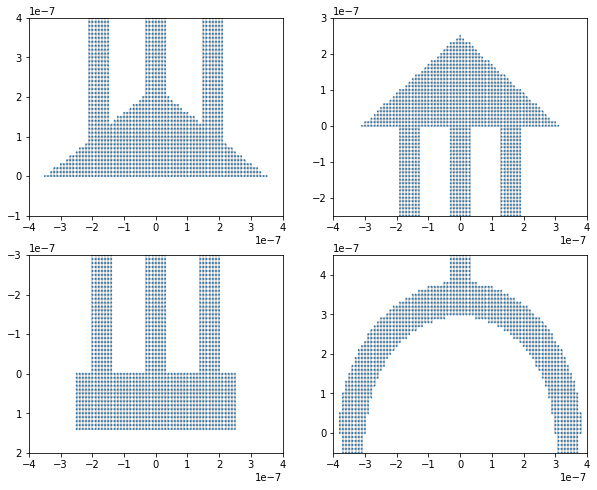

In [127]:
lims = np.array([
    [[-4, 4], [-1, 4]],
    [[-4, 4], [-2.5, 3]],
    [[-4, 4], [2, -3]],
    [[-4, 4], [-0.5, 4.5]]
])*1e-7

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
i = 0
for ax in axes.flatten():
    kwant.plot(nice_tjs[i][0], ax=ax)
    ax.set_xlim(lims[i][0])
    ax.set_ylim(lims[i][1])
    i += 1

# MBS coupling

In [138]:
mus_qd_1 = np.linspace(-0.0015, 0.0015, 100)
key = 'mu_qd'
n = 6
eigen = tl.solver(geometries=nice_tjs[:3], n=n, key=key, eigenvecs=False)

In [129]:
def wrap(args):
    return eigen(*args)

In [130]:
index = 0

params = tl.finite_coupling_parameters(index=index)

args = list(it.product(range(3), mus_qd, params))
args_db = db.from_sequence(args, npartitions=20)
result_triangles = args_db.map(wrap).compute()

In [131]:
geometries_ens = []
geometries_wfs = []
geometries_peaks = []
data_geometries = tl.separate_data_geometries(data=result_triangles, n_geometries=3)
for geometry in data_geometries:
    couplings, wfs, peaks = tl.coupling_data(data=geometry, sign=1)
    geometries_ens.append(couplings)
    geometries_wfs.append(wfs)
    geometries_peaks.append(peaks)

In [132]:
geometries_ens = np.array(geometries_ens)

In [139]:
mus_qd_2 = np.linspace(0, 0.0025, 100)
key = 'mu_qd'
n = 6
eigen = tl.solver(geometries=[nice_tjs[-1]], n=n, key=key, eigenvecs=True)

In [134]:
def wrap(args):
    return eigen(*args)

In [135]:
index = 0

params = tl.finite_coupling_parameters(index=index)

args = list(it.product([0], mus_qd, params))
args_db = db.from_sequence(args, npartitions=20)
result_ring = args_db.map(wrap).compute()

In [136]:
ens_r, wfs_r, _ = tl.coupling_data(result_ring)

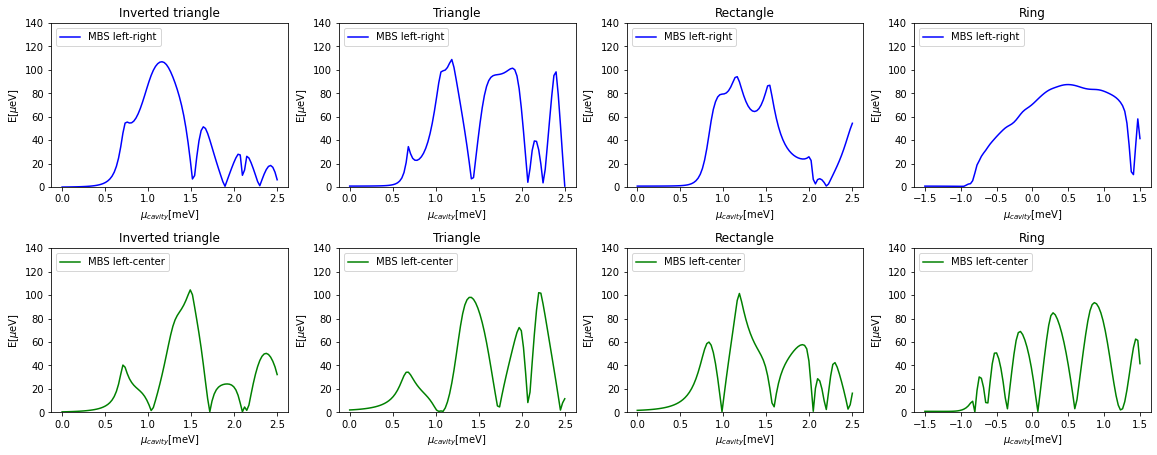

In [140]:
labels = ['Inverted triangle', 'Triangle', 'Rectangle', 'Ring']
colors = ['blue', 'green']
legends = ['MBS left-right', 'MBS left-center']
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(16, 6))
fig.tight_layout(h_pad=4, w_pad=2)
geometry = 0
pair = 0
for ax in axes.flatten():
    if geometry > 3:
        pair = 1
        geometry = 0
    if geometry == 3:
        ax.plot(1e3*mus_qd_1, 1e6*ens_r[pair], color=colors[pair], label=legends[pair])
    else:
        ax.plot(1e3*mus_qd_2, 1e6*geometries_ens[geometry][pair], label=legends[pair], color=colors[pair])
    ax.set_title(labels[geometry])
    ax.set_ylim(0, 140)
    ax.set_ylabel(r'E[$\mu$eV]')
    ax.set_xlabel(r'$\mu_{cavity}$[meV]')
    ax.legend(loc='upper left')
    geometry += 1

# Effective Hamiltonian with hKPM

In [5]:
def lowdin_partition(system, hamiltonian, cut=0):

    PL = kwant.operator.Density(system,
                                where=lambda site: site.pos[1] < cut,
                                sum=True).tocoo()
    PR = kwant.operator.Density(system,
                                where=lambda site: site.pos[1] >= cut,
                                sum=True).tocoo()

    PL = csc_matrix(PL)[PL.getnnz(1) > 0]
    PR = csc_matrix(PR)[PR.getnnz(1) > 0]

    # Extract uncoupled sectors
    HL = PL @ hamiltonian @ PL.T
    HR = PR @ hamiltonian @ PR.T
    # Write uncoupled Hamiltonian
    H_partition = PR.T @ HR @ PR + PL.T @ HL @ PL

    return csc_matrix(H_partition)


def prepare_perturbation(system, key, val, unperturbed_hamiltonian, f_params, **parameters):

    parameters[key] = val
    perturbed_hamiltonian = system.hamiltonian_submatrix(params=f_params(**parameters), sparse=True)

    energies, _ = tl.sort_eigen(sla.eigsh(perturbed_hamiltonian, sigma=0, k=8))

    block_hamiltonian = lowdin_partition(system, perturbed_hamiltonian)

    barrier_perturbation = unperturbed_hamiltonian - perturbed_hamiltonian
    hopping_perturbation = unperturbed_hamiltonian - block_hamiltonian

    return energies, csc_matrix(barrier_perturbation), csc_matrix(hopping_perturbation)

In [6]:
n_geometries = 10
angles = np.linspace(0.05, 0.35, n_geometries)
angle_inverted = angles[4]*np.pi
angle_non_inverted = angles[5]*np.pi
area = 800*a**2

geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'down',
    "shape": 'triangle',
    "A": area,
    "angle": angle_non_inverted
}

In [7]:
center = np.sqrt(np.abs(area/np.tan(angle_non_inverted)))/2
geometry.update(centers=[center, -center])
triangle, f_params_t, _ = tj.finite_system(**geometry)
triangle = triangle.finalized()

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


In [8]:
params = tl.junction_parameters(m_nw=0, m_qd=0)
mu = tl.bands[0]


In [9]:
orthogonal_evecL = []
params.update(sigma=0)
for w in wires_isolated:
    params.update(mus_nw=w)
    hamiltonian = triangle.hamiltonian_submatrix(params=f_params_t(**params), sparse=True)
    system = triangle
    cut = 0


    PL = kwant.operator.Density(system,
                                where=lambda site: site.pos[1] < cut,
                                sum=True).tocoo()
    PR = kwant.operator.Density(system,
                                where=lambda site: site.pos[1] >= cut,
                                sum=True).tocoo()

    PL = csc_matrix(PL)[PL.getnnz(1) > 0]
    PR = csc_matrix(PR)[PR.getnnz(1) > 0]

    # Extract uncoupled sectors
    HL = PL @ hamiltonian @ PL.T
    HR = PR @ hamiltonian @ PR.T
    # Write uncoupled Hamiltonian
    H_partition = PR.T @ HR @ PR + PL.T @ HL @ PL

    k = 40
    evL, evecL = tl.sort_eigen(sla.eigsh(HL, sigma=0, k=1))
    orthogonal_evecL.append(evecL[0])

evR, evecR = tl.sort_eigen(sla.eigsh(HR, sigma=0, k=k))

In [10]:
params = tl.junction_parameters(m_nw=0, m_qd=-0.001)
params.update(tl.finite_coupling_parameters(index=0)[0])
hamiltonian = triangle.hamiltonian_submatrix(params=f_params_t(**params), sparse=True)
H0 = lowdin_partition(system=triangle, hamiltonian=hamiltonian)

In [11]:
orthogonal_evecL = np.array(orthogonal_evecL)

In [15]:
H0 = csc_matrix(H0)

In [16]:
density = kwant.operator.Density(triangle, np.eye(4))

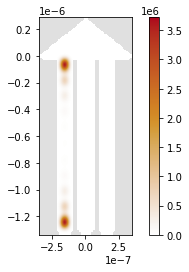

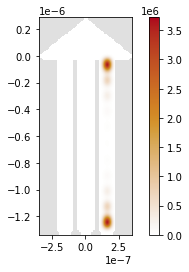

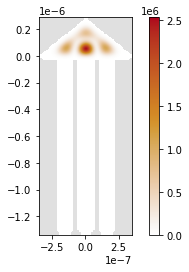

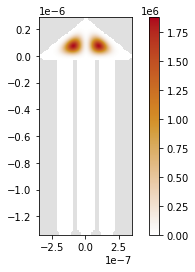

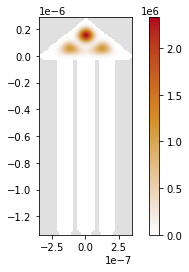

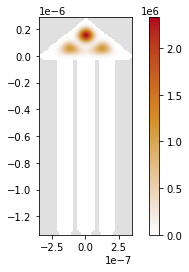

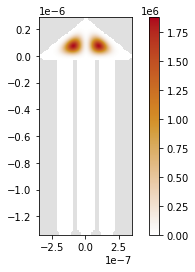

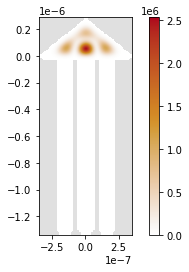

In [17]:
for i in range(8):
    kwant.plotter.density(triangle, density(A_basis.T[i]));

In [22]:
mus_qd = np.linspace(-0.001, 0.00025, 25)

In [23]:
params = tl.junction_parameters(m_nw=0, m_qd=0)
params.update(tl.finite_coupling_parameters(index=0)[0])

en = []
vc = []
Hcoup = []
Hgate = []
for bar in mus_qd:
    energies, barrier, hopping = prepare_perturbation(system=triangle,
                                                       key='mu_qd',
                                                       val=bar,
                                                       unperturbed_hamiltonian=hamiltonian,
                                                       f_params=f_params_t,
                                                       **params)
    en.append(energies)
    Hcoup.append(hopping)
    Hgate.append(barrier)

Text(0.5, 1.0, 'Single nanowire: $W=a$')

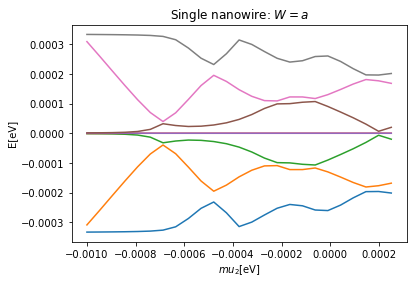

In [24]:
for level in np.array(en).T:
    plt.plot(mus_qd, np.array(level))
    #plt.plot(mus[:,1], level)
plt.xlabel(r"$mu_{2}$[eV]")
plt.ylabel(r"E[eV]")
plt.title(r"Single nanowire: $W=a$")

In [70]:
def calculate_effective_models(Hgate, Hcoup, A_basis, B_basis):

    def solver(index, order):
        eff = effective.effective_model(H0=H0, H1={'gate': Hgate[index], 'p': Hcoup[index]},
                                        evec_A=A_basis,
                                        evec_B=B_basis,                                     
                                        order=order,
                                        kpm_params=dict(num_moments=1000))

        models = kwant.continuum.lambdify(sympy.expand(eff.tosympy()))
        return model

    return solver

def get_mats(p, gate, models, l, m=0):
    mats = []
    energies = []

    for i in range(l):
        if i == m:
            mats.append(models[i](p=p))
        else:
            mats.append(models[i](p=p, gate=gate))
        energies.append(la.eigvalsh(mats[i]))

    return mats, energies

In [56]:
import sympy
models1 = []
models2 = []
for i in range(len(mus_qd)):
    print(i)
    eff1 = effective.effective_model(H0=H0, H1={'gate': Hgate[i], 'p': Hcoup[i]},
                                    evec_A=A_basis,
                                    #evec_B=B_basis,                                     
                                    order=1,
                                    kpm_params=dict(num_moments=1000))
    models1.append(kwant.continuum.lambdify(sympy.expand(eff1.tosympy())))
    eff2 = effective.effective_model(H0=H0, H1={'gate': Hgate[i], 'p': Hcoup[i]},
                                    evec_A=A_basis,                                 
                                    #evec_B=B_basis,                                     
                                    order=2,
                                    kpm_params=dict(num_moments=1000))
    models2.append(kwant.continuum.lambdify(sympy.expand(eff2.tosympy())))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [ ]:
models3 = []

for i in range(len(mus_qd)):
    print(i)
    eff3 = effective.effective_model(H0=H0, H1={'gate': Hgate[i], 'p': Hcoup[i]},
                                    evec_A=A_basis,
                                    evec_B=B_basis,                                     
                                    order=3,
                                    kpm_params=dict(num_moments=1000))
    models3.append(kwant.continuum.lambdify(sympy.expand(eff3.tosympy())))

In [ ]:
mat1, energies1 = get_mats(p=-4.35, gate=3.3, models=models1, l=len(mus_qd))

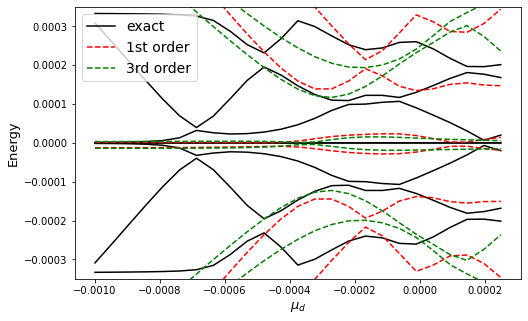

In [59]:
mat1, energies1 = get_mats(p=-4.6, gate=3.55, models=models1, l=len(mus_qd))
mat2, energies2 = get_mats(p=-3.9, gate=3.125, models=models2, l=len(mus_qd))
#mat2, energies3 = get_mats(p=-1.99, gate=1, models=models3, l=len(mus_qd))
#mat1, mat2, _, energies2 = get_mats(p=-3.92, gate=3.125)
fig, ax = plt.subplots(figsize=(8, 5))

for level in np.array(en).T:
    plt.plot(mus_qd, np.array(level), color='black', label='exact')

plt.plot(mus_qd, energies1, 'r--', label='1st order')
plt.plot(mus_qd, energies2, 'g--', label='3rd order')
#handles, labels = plt.gca().get_legend_handles_labels()
plt.ylim(-0.35e-3, 0.35e-3)
plt.xlabel(r'$\mu_d$', fontsize=13)
plt.ylabel('Energy', fontsize=13)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize=14)

Text(0, 0.5, 'Energy')

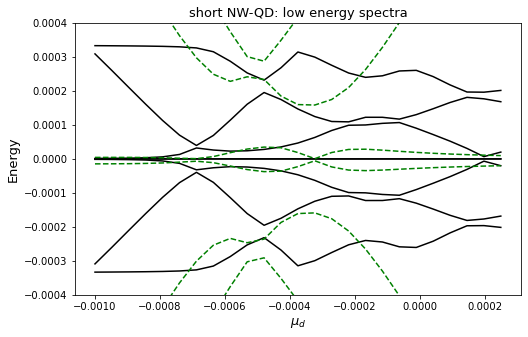

In [69]:
mat2, energies2 = get_mats(p=-7.6, gate=5.85, models=models1, l=len(mus_qd))
fig, ax = plt.subplots(figsize=(8, 5))

for level in np.array(en).T:
    plt.plot(mus_qd, np.array(level), color='black')

#plt.plot(mus_qd, energies1, 'r--', label='1st order'
plt.plot(mus_qd, energies2, 'g--', label='3rd order')
handles, labels = plt.gca().get_legend_handles_labels()
plt.ylim(-0.4e-3, 0.4e-3)
plt.title('short NW-QD: low energy spectra', fontsize=13)
plt.xlabel(r'$\mu_d$', fontsize=13)
plt.ylabel('Energy', fontsize=13)

# Chemical potential disorder in the cavity

In [54]:
mus_qd = np.linspace(-0.0015, 0.0015, 100)
index = 0

key = 'mu_qd'
n = 6
eigen = tl.solver(geometries=[nice_tjs[1]], n=n, key=key, eigenvecs=False)

In [55]:
def wrap(args):
    return eigen(*args)

In [56]:
params = tl.finite_coupling_parameters(index=0, sigma=1e-4)
args = list(it.product([0], mus_qd, params))
args_db = db.from_sequence(args, npartitions=20)

In [53]:
#cluster.adapt(minimum=4, maximum=20)

In [57]:
data_sigmas = []

n_experiments = 10
sigmas = np.linspace(1e-4, 1e-3, 5)

for sigma in sigmas:
    data_sigma = []

    extra_params = tl.finite_coupling_parameters(index=index, sigma=sigma)
    args = list(it.product([0], mus_qd, extra_params))
    args_db = db.from_sequence(args, npartitions=20)
    for i in range(n_experiments):

        result = args_db.map(wrap).compute()
        couplings, _, _ = tl.coupling_data(result)
        data_sigma.append(couplings)
    data_sigmas.append(data_sigma)

AttributeError: module 'numpy' has no attribute 'arraY'

In [58]:
data_sigmas = np.array(data_sigmas)

In [67]:
mean = np.mean(data_sigmas[-1].T, axis=2)
np.shape(mean)

(100, 3)

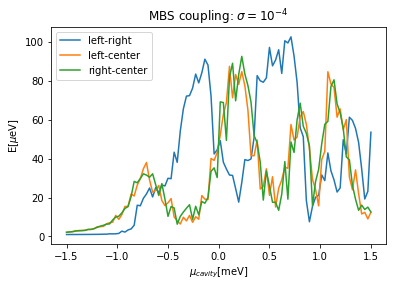

In [77]:
lineObjects = plt.plot(1e3*mus_qd, 1e6*mean)
plt.xlabel(r'$\mu_{cavity}$[meV]')
plt.ylabel(r'E[$\mu$eV]')
plt.title(r'MBS coupling: $\sigma=10^{-4}$')
plt.legend(iter(lineObjects), ('left-right', 'left-center', 'right-center'))